Set some cell magics

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import everything that's needed. This also brings for example numpy imported as np.

In [2]:
from fastai import *
from fastai.vision import *

Set batch size and path for images, also class names

In [3]:
batch_size = 64
path = Path('/home/jupyter/big_cats/big_cats/')

classes = ['caracal',
           'cheetah', 
           'clouded leopard', 
           'cougar', 
           'jaguar',
           'jungle cat',
           'leopard',
           'lion',
           'lynx',
           'serval',
           'snow leopard', 
           'sunda clouded leopard', 
           'tiger']

Verify that all images can be opened and are three channel images

In [4]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True)

caracal


Image /home/jupyter/big_cats/big_cats/caracal/147. canva-caracal%2c-caracal-caracal%2c-6-months-old-maassdokdh0.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/caracal/157. three_caracat.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/caracal/144. 3fd0aee154c496ead9e6273815d9d2c4.png has 4 instead of 3 channels
cheetah


clouded leopard


cougar


jaguar


jungle cat


Image /home/jupyter/big_cats/big_cats/jungle cat/51. a-three-months-old-kitten-of-the-jungle-cat-felis-chaus-courtesy-of-turovski-tallinn.png has 1 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/jungle cat/112. the-jungle-cat-felis-chaus-guldenstaedt-1776-carnivora-felidae.png has 4 instead of 3 channels
leopard


lion


lynx


Image /home/jupyter/big_cats/big_cats/lynx/63. lynx-opener-usfws-keith-williams.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/151. lynx.gif has 1 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/115. photograph-of-canadian-lynx-and-snowshoe-hare-balance-problem-used-in-consolidity-theory.png has 1 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/165. lynx.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/4. lynx-reuters.jpeg has 1 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/292. lynx-possible-opener.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/8. lynx-640x503.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/153. lynx_and_hare1.png has 1 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/98. main-lynx-trentu.png has 4 instead of 3 channels
Image /home/jupyter/big_cats/big_cats/lynx/58. canada-lynx_alanna-schmidt.

Image /home/jupyter/big_cats/big_cats/serval/120. 20110709-d2x_3797-s.jpg has 1 instead of 3 channels
snow leopard


sunda clouded leopard


tiger


Put data into ImageDataBunch

In [5]:
ds_tfms = get_transforms()
data = (ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms=ds_tfms, size=224)
        .databunch(bs=batch_size)).normalize(imagenet_stats)

See what data contains

In [6]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (3345 items)
[Category sunda clouded leopard, Category sunda clouded leopard, Category sunda clouded leopard, Category sunda clouded leopard, Category sunda clouded leopard]...
Path: /home/jupyter/big_cats/big_cats
x: ImageItemList (3345 items)
[Image (3, 683, 1024), Image (3, 350, 500), Image (3, 467, 700), Image (3, 337, 236), Image (3, 360, 480)]...
Path: /home/jupyter/big_cats/big_cats;

Valid: LabelList
y: CategoryList (836 items)
[Category lynx, Category cougar, Category cheetah, Category sunda clouded leopard, Category cougar]...
Path: /home/jupyter/big_cats/big_cats
x: ImageItemList (836 items)
[Image (3, 401, 534), Image (3, 360, 480), Image (3, 470, 560), Image (3, 1067, 1600), Image (3, 1121, 1500)]...
Path: /home/jupyter/big_cats/big_cats;

Test: None

Show example batch

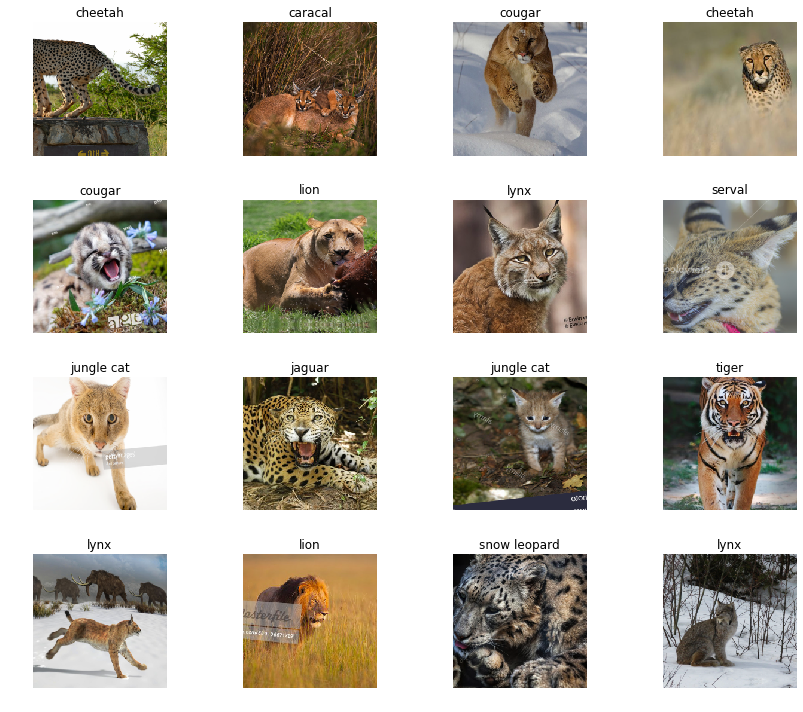

In [8]:
data.show_batch(rows=4, cols=4, figsize=(12,10))

Refit our model on top of resnet50. 

In [9]:
big_cat_cnn = create_cnn(data, models.resnet50, metrics=error_rate)
big_cat_cnn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.970668,0.337241,0.110048
2,0.520977,0.287488,0.099282
3,0.372506,0.261292,0.096890
4,0.248836,0.236738,0.075359
5,0.191667,0.238347,0.081340


Seems okay-ish, let's save first stage

In [11]:
big_cat_cnn.save('/home/jupyter/ties4911/ex4/models/big_cats_fastai_stage1)

Interpret classifications by examining top 9 losses and confusion matrix, and most confused species

In [12]:
interp = ClassificationInterpretation.from_learner(big_cat_cnn)

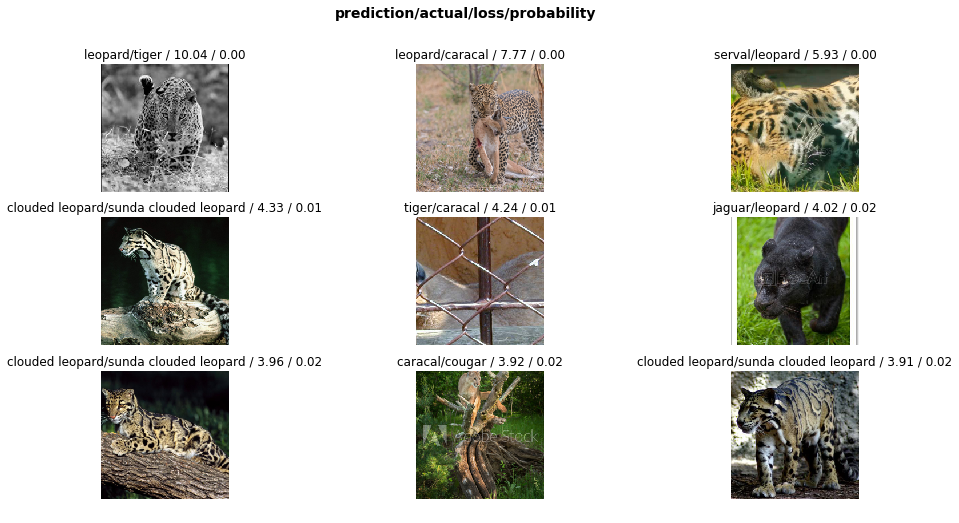

In [13]:
interp.plot_top_losses(9, figsize=(16,8))

As you can see, some of our losses are due to mislabelling or some other errors, like top loss that is clearly a leopard. Also there is both leopard and caracal on second highest loss image.

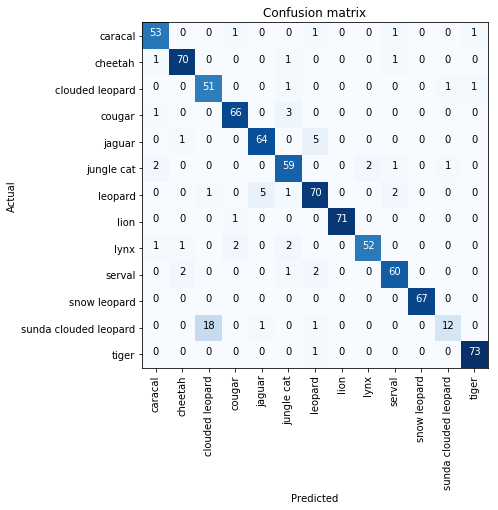

In [21]:
plt.rcParams['figure.figsize'] = (7,7)
interp.plot_confusion_matrix()

In [17]:
interp.most_confused()

[('sunda clouded leopard', 'clouded leopard', 18),
 ('jaguar', 'leopard', 5),
 ('leopard', 'jaguar', 5),
 ('cougar', 'jungle cat', 3),
 ('jungle cat', 'caracal', 2),
 ('jungle cat', 'lynx', 2),
 ('leopard', 'serval', 2),
 ('lynx', 'cougar', 2),
 ('lynx', 'jungle cat', 2),
 ('serval', 'cheetah', 2),
 ('serval', 'leopard', 2)]

Most common mix-ups are between sunda clouded leopard and clouded leopard which is expected.

Next fine-tune a bit more, first search for optimal learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


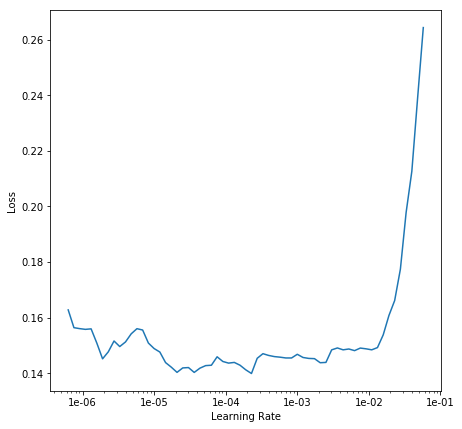

In [23]:
big_cat_cnn.lr_find()
big_cat_cnn.recorder.plot()

Optimal learning rate seems to be somewhere between about 8e-06 and 4e-05

In [24]:
big_cat_cnn.unfreeze()
big_cat_cnn.fit_one_cycle(5, max_lr=slice(8e-06, 4e-05))

epoch,train_loss,valid_loss,error_rate
1,0.156731,0.226926,0.074163
2,0.142918,0.217887,0.069378
3,0.110298,0.213121,0.064593
4,0.100378,0.211222,0.065789
5,0.095557,0.207792,0.063397


Seems that model improved a bit. Let's check interpretations

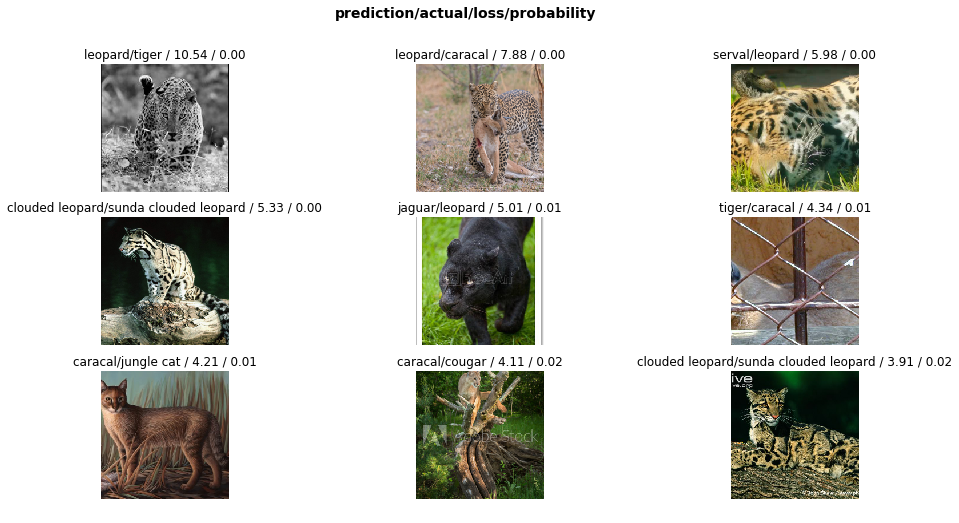

In [25]:
interp = ClassificationInterpretation.from_learner(big_cat_cnn)
interp.plot_top_losses(9, figsize=(16,8))

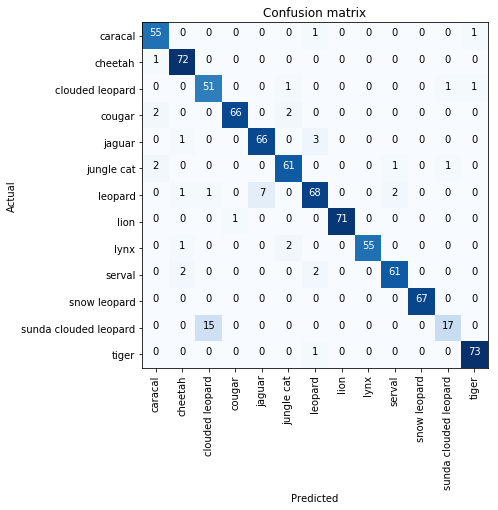

In [26]:
interp.plot_confusion_matrix()

In [28]:
interp.most_confused()

[('sunda clouded leopard', 'clouded leopard', 15),
 ('leopard', 'jaguar', 7),
 ('jaguar', 'leopard', 3),
 ('cougar', 'caracal', 2),
 ('cougar', 'jungle cat', 2),
 ('jungle cat', 'caracal', 2),
 ('leopard', 'serval', 2),
 ('lynx', 'jungle cat', 2),
 ('serval', 'cheetah', 2),
 ('serval', 'leopard', 2)]

In [30]:
big_cat_cnn.save('/home/jupyter/ties4911/ex4/models/big_cats_fastai_stage2', return_path=True)

PosixPath('/home/jupyter/ties4911/ex4/models/big_cats_fastai_stage2.pth')